# XGBoost Extended Model Predict density in same frame
> Created Feb. 2025 <br>
> Nikhil Bisht<br>

In [23]:
# standard system modules
import os, sys
os.environ["PATH"] += os.pathsep + "/home/nbisht/myapps/bin/"
import h5py 
import argparse
# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np
from itertools import permutations

# standard statistical module
import scipy.stats as st
from scipy import linalg
from scipy.stats import ks_2samp


# standard module for high-quality plots
from PIL import Image
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
mp.rcParams.update(mp.rcParamsDefault)
%matplotlib inline

# to plot pixelized images
import imageio.v3 as im

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tables
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split,RepeatedKFold,cross_val_score
import xgboost as xgb

import sklearn.metrics as skm

from tqdm import tqdm

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

DATAFILE  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_ML_dataset_AllData_AutoEnc.h5'
CORESET  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_all_frames.h5'
MODELFILE = 'nnmodel.json'

IMAGESIZE = 128

#In percentage
NTRAIN_percentage =  0.85
NVALID_percentage =  0.05
NTEST_percentage  =  0.15

ALL_COLUMNS = ['Particle_id', 'Frame', 'X', 'Y', 'Z', 'Density']
FEATURES = ALL_COLUMNS[1:5]
TARGET = ALL_COLUMNS[5]

FRAMES = np.arange(30,100, 1)
FRAME_DIFF = 30

NUM_X_TRAIN = 13

#DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')

print(f'Available device: {str(DEVICE):4s}')

Available device: cpu 


## Load data

In [24]:
def get_timeseries_df(datafile, coreset, frames, frame_diff, concat_df = False):
    df_core_pids =[]
    with h5py.File(coreset, 'r') as f:
        tm = f['track_manager']
        df_core_pids = tm['particle_ids'][()]
        
    #get data and prepare sample
    df_timeseries_core = pd.DataFrame([], columns=ALL_COLUMNS)
    df_timeseries_noncore = pd.DataFrame([], columns=ALL_COLUMNS)
    f =  h5py.File(datafile, 'r')
    for frame_num_index in range(len(frames)):
        frame_num = frames[frame_num_index]
        print(frame_num , end = ' ')
        temp_df_timeseries = pd.DataFrame([], columns=FEATURES)
        f_frame_ini = f[str(frame_num)]
        temp_df_timeseries['Frame'] = np.repeat(frame_num, len(f_frame_ini['Particle_id'][()]))
        temp_df_timeseries['Particle_id'] = f_frame_ini['Particle_id'][()]
        temp_df_timeseries['Particle_id'] = temp_df_timeseries['Particle_id'].astype('int32')
        temp_df_timeseries = temp_df_timeseries.set_index('Particle_id')
        for cname in ['X', 'Y', 'Z', 'Density']:
            temp_df_timeseries[cname] = f_frame_ini[cname][()]
        temp_df_timeseries_core = temp_df_timeseries.loc[df_core_pids]
        temp_df_timeseries_noncore = temp_df_timeseries.drop(df_core_pids)
        temp_df_timeseries_core = temp_df_timeseries_core.reset_index(names='Particle_id')
        temp_df_timeseries_noncore = temp_df_timeseries_noncore.reset_index(names='Particle_id')
        if frame_num_index == 0:
            df_timeseries_core = temp_df_timeseries_core
            df_timeseries_noncore = temp_df_timeseries_noncore
        else:
            df_timeseries_core = pd.concat([df_timeseries_core, temp_df_timeseries_core])
            df_timeseries_noncore = pd.concat([df_timeseries_noncore, temp_df_timeseries_noncore])
    f.close()

    df_timeseries_core['Density'] = np.log10(df_timeseries_core['Density'])
    df_timeseries_noncore['Density'] = np.log10(df_timeseries_noncore['Density'])
    print(' ')
    if concat_df:
        df_timeseries = pd.concat([df_timeseries_core, df_timeseriedf_timeseries_cores_noncore])
        return df_core_pids, df_timeseries
    else:
        return df_core_pids, df_timeseries_core, df_timeseries_noncore

nb101_core_pids, nb101_df, nb101_df_noncore = get_timeseries_df(DATAFILE, CORESET, FRAMES, FRAME_DIFF, concat_df = False)

print(len(nb101_df))
print(len(nb101_df_noncore))



30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99  
8215480
138585160


In [25]:
df_timeseries = nb101_df.copy()
df_timeseries.head()

,Particle_id,Frame,X,Y,Z,Density
0,1405,30,0.548724,0.157302,0.951530,-0.076494
1,1488,30,0.082750,0.207655,0.949522,-0.099267
2,1489,30,0.092412,0.216760,0.954083,-0.044801
3,1490,30,0.101305,0.218718,0.957615,-0.033727
4,1531,30,0.534520,0.165883,0.983209,-0.545806


In [26]:
df_timeseries.describe()

,Particle_id,Frame,X,Y,Z,Density
count,8.215480e+06,8.215480e+06,8.215480e+06,8.215480e+06,8.215480e+06,8.215480e+06
mean,9.660910e+05,6.450000e+01,4.367052e-01,5.445161e-01,5.275762e-01,1.495587e+00
std,5.546922e+05,2.020520e+01,2.836763e-01,2.332449e-01,3.627606e-01,1.341259e+00
min,1.405000e+03,3.000000e+01,1.175781e-07,7.587683e-08,1.180996e-07,-1.533651e+00
25%,6.183888e+05,4.700000e+01,1.759744e-01,3.976350e-01,1.689889e-01,6.698448e-01
50%,7.553815e+05,6.450000e+01,4.340778e-01,5.648038e-01,5.633925e-01,1.231703e+00
75%,1.396570e+06,8.200000e+01,6.181729e-01,7.461200e-01,9.115981e-01,1.883263e+00
max,2.096225e+06,9.900000e+01,9.999998e-01,1.000000e+00,1.000000e+00,6.962599e+00


## Split data

In [27]:
def plot_prediction(y_true,y_pred, mae, r2, append=''):
    fig = plt.figure(figsize=(6, 6))
    for i in range(1):
        ax = plt.subplot(1, 1, i+1)
        ax.scatter(y_true,y_true-y_pred, c='crimson', s=1e-2)
        ax.plot([0, 0], [1, 1], 'b-')
        ax.set_xlabel('True Values', fontsize=15)
        ax.set_ylabel('True Values - Predictions', fontsize=15)
        ax.set_title(f'{TARGET[i]}: MAE = {mae:.6f}, R2 = {r2:.4f}', fontsize=12)
        #ax.set_xlim([-0.1,1.1])
        #ax.set_ylim([-0.1,1.1])
    fig.tight_layout()
    plt.savefig('Particles_u502_Prediction'+append+'.png')
    plt.show()


def model_test(model, test_df):
    y_pred = model.predict(test_df[FEATURES])
    return y_pred

In [28]:
X, y = df_timeseries[FEATURES], df_timeseries[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = NTEST_percentage,  random_state=seed)


## Train model
https://xgboost.readthedocs.io/en/stable/parameter.html

In [29]:
n_estimators    = 1000   #The number of trees in the ensemble, often increased until no further improvements are seen.
max_depth       = 9     #The maximum depth of each tree, often values are between 1 and 10.
eta             = 0.3  #The learning rate used to weight each model, often set to small values such as 0.3, 0.1, 0.01, or smaller.
subsample       = 1   #The number of samples (rows) used in each tree, set to a value between 0 and 1, often 1.0 to use all samples.
colsample_bytree= 1     #Number of features (columns) used in each tree, set to a value between 0 and 1, often 1.0 to use all features.

#We will evaluate the model using the best practice of repeated k-fold cross-validation with 3 repeats and 10 folds.
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

model = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators=n_estimators, max_depth=max_depth, eta=eta, subsample=subsample, colsample_bytree=colsample_bytree, device = 'cpu')

evaluate = 0
if evaluate:
    # evaluate model
    model_score = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-3)
    # force scores to be positive
    scores = np.absolute(model_score)
    print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )


In [30]:
print(len(X_train))
model.fit(X_train, y_train)

6983158


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device='cpu', early_stopping_rounds=None, enable_categorical=False,
             eta=0.3, eval_metric=None, feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, ...)

In [31]:
model.save_model("Core_Density_only_v0_"+MODELFILE)

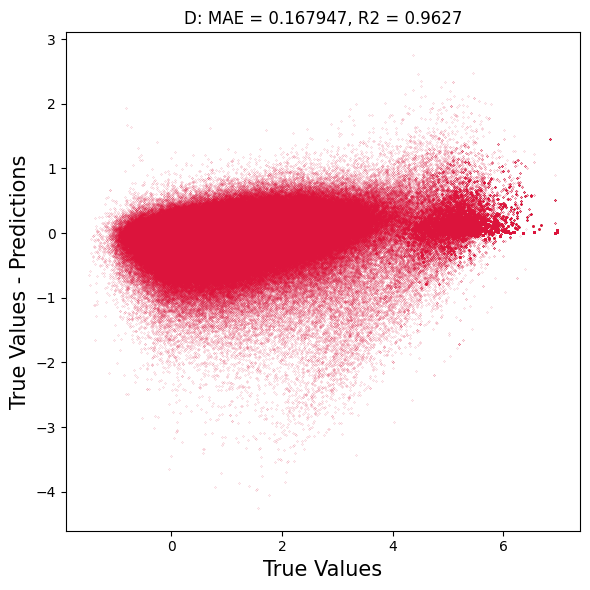

MaE: 0.167947
R2: 0.963


In [32]:
model = xgb.XGBRegressor()
mtype = 'Core'
model.load_model(mtype+'_Density_only_v0_nnmodel.json')
ypred, ytrue = model_test(model, X_test), y_test
mae = skm.mean_absolute_error(ytrue.to_numpy(), ypred)
r2 = skm.r2_score(ytrue.to_numpy(),ypred)
plot_prediction(ytrue.to_numpy(),ypred,mae, r2 , append = '_'+mtype+'_Density_only_v0')
print('MaE: %.6f' % mae)
print('R2: %.3f' % r2)



## Stats
| Model 	| Loss 	        | n_estimators 	| max_depth 	| eta 	| subsample 	| lambda 	| alpha 	| Density R2 	| Density mae 	| r2 	| remarks 	                                     |
|-------	|-------        |--------------	|-----------	|-----	|-----------	|--------	|-------	|----------	|------	|----	|---------	                                    |
|V0 |squarederror   |1000          	|  8        	|0.1   | 1        	|   1    	|    1  	|0.9225     |0.144852|0.959| Deeper tree|
